In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [53]:
data = pd.read_csv("data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [54]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8820, 34)
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)


In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

   #not all models have predict_proba
    if callable(getattr(model, "predict_proba", None)):
        soft_predictions = model.predict_proba(test)[:,1]
        print("ROC AUC: "+str(roc_auc_score(truth,soft_predictions)))
    
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Attempt 2
---
## Issues with the first attempt
---
We found that our first attempt varied (in accuracy) greatly between different random test sets. This could indicate overfitting portions of the data. This could be due to a relatively small dataset size, which leads to the classifier not being able to really learn the correct things. 

---
## Improvement ideas
---
First, we will try to see if performance goes up if we try to train a "good frame" vs "bad frame" binary classifier, instead of a "good clip" vs "bad clip" binary classifier. The idea is that this will significantly increase the size of the dataset that we have available to us, helping the classifier generalize a bit more. 

If this yields improved results, we will then try to extend this concept of "good frames" vs "bad frames" by trying to create a basic composite score for each clip based on its proportion of good frames and bad frames. We can output this both as a soft score (the exact percentage of good vs bad) and as a hard score (if more good frames, we predict good clip, if more bad frames, we predict bad clip).

---
### Frame by Frame Classifier
---

In [56]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier(silent= True)
cbm.fit(X_train,y_train)

Learning rate set to 0.022413
0:	learn: 0.6891090	total: 7.18ms	remaining: 7.18s
1:	learn: 0.6848768	total: 15.6ms	remaining: 7.76s
2:	learn: 0.6800817	total: 21.5ms	remaining: 7.13s
3:	learn: 0.6767865	total: 29.6ms	remaining: 7.38s
4:	learn: 0.6732185	total: 35.6ms	remaining: 7.09s
5:	learn: 0.6698081	total: 41.9ms	remaining: 6.94s
6:	learn: 0.6660084	total: 50.6ms	remaining: 7.18s
7:	learn: 0.6630608	total: 71.5ms	remaining: 8.87s
8:	learn: 0.6593857	total: 81.8ms	remaining: 9.01s
9:	learn: 0.6563488	total: 94.3ms	remaining: 9.33s
10:	learn: 0.6532475	total: 106ms	remaining: 9.51s
11:	learn: 0.6503813	total: 121ms	remaining: 9.97s
12:	learn: 0.6470287	total: 131ms	remaining: 9.98s
13:	learn: 0.6441194	total: 144ms	remaining: 10.2s
14:	learn: 0.6418899	total: 159ms	remaining: 10.4s
15:	learn: 0.6390133	total: 170ms	remaining: 10.4s
16:	learn: 0.6367360	total: 177ms	remaining: 10.2s
17:	learn: 0.6343857	total: 184ms	remaining: 10s
18:	learn: 0.6318517	total: 193ms	remaining: 9.95s
19:

CATBOOST REV 2 STATS:
ACCURACY: 0.890400604686319
ROC AUC: 0.9551651217364624


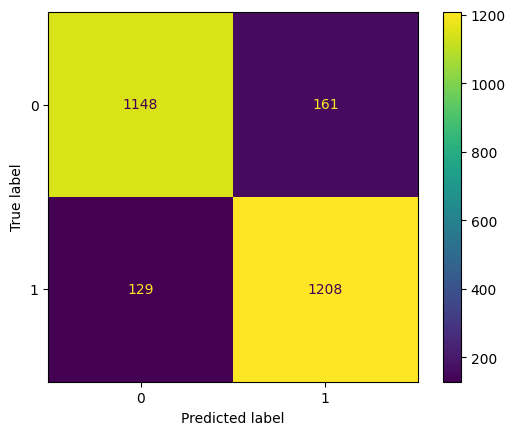

In [57]:
displayStats(cbm, "CATBOOST REV 2", X_test, y_test)

### Sanity Check

---

Let's generate a histogram of multiple CBTrees on different splits, and their respective statistics

In [58]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    data = pd.read_csv("data_nonconcat.csv",header=None)
    data = data.sample(frac=1)
    data = data.reset_index(drop=True)
    labels = data[0]
    data = data.drop(0,axis='columns')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.asarray(y_train.values.tolist())
    y_train = y_train.reshape(-1,1)
    y_test = np.asarray(y_test.values.tolist())
    y_test = y_test.reshape(-1,1)

    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train,y_train)

    predictions = cbm.predict(X_test) #all of them should have this
    print("ACCURACY: "+str(accuracy_score(y_test,predictions)))
    acc = accuracy_score(y_test,predictions)
    accuracies.append(acc)

print(accuracies)

ACCURACY: 0.8888888888888888
ACCURACY: 0.9024943310657596
ACCURACY: 0.8851095993953136
ACCURACY: 0.8873771730914588
ACCURACY: 0.881708238851096
ACCURACY: 0.8851095993953136
ACCURACY: 0.8866213151927438
ACCURACY: 0.8945578231292517
ACCURACY: 0.8881330309901738
ACCURACY: 0.8892668178382465
ACCURACY: 0.8907785336356765
ACCURACY: 0.8873771730914588
ACCURACY: 0.8934240362811792
ACCURACY: 0.8847316704459561
ACCURACY: 0.8892668178382465
ACCURACY: 0.8949357520786092
ACCURACY: 0.9051398337112623
ACCURACY: 0.8938019652305367
ACCURACY: 0.9028722600151171
ACCURACY: 0.8907785336356765
ACCURACY: 0.9017384731670446
ACCURACY: 0.8877551020408163
ACCURACY: 0.8862433862433863
ACCURACY: 0.8934240362811792
ACCURACY: 0.8858654572940288
ACCURACY: 0.8907785336356765
ACCURACY: 0.889644746787604
ACCURACY: 0.8900226757369615
ACCURACY: 0.889644746787604
ACCURACY: 0.8915343915343915
ACCURACY: 0.9074074074074074
ACCURACY: 0.8869992441421013
ACCURACY: 0.891156462585034
ACCURACY: 0.8907785336356765
ACCURACY: 0.891156

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

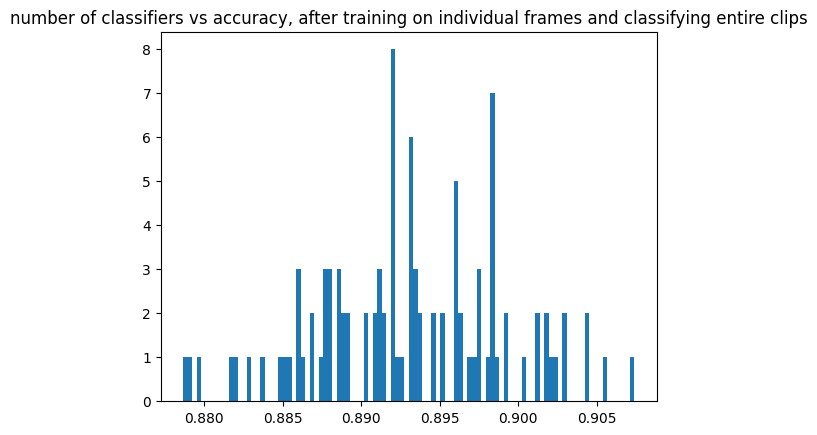

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

### Conclusions of Frame by Frame classifier

---
The frame by frame classifier seems to do really well on random frames. We can now try to extend this concept to classifying on each clip. 

---


## Clip by Clip Classifier

---

1. Import the concatenated vector data so that we have an entire clip as a row

In [59]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [60]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    74
1.0    73
Name: 0, dtype: int64
1.0    51
0.0    51
dtype: int64
0.0    23
1.0    22
dtype: int64


In [61]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)
CONCAT DATA SHAPES
(102, 2040)
(45, 2040)
(102, 1)
(45, 1)


2. Reshape to extract frame-by-frame 

In [62]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [63]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.copy(y_train_C)
y_test_Cr = np.copy(y_test_C)

y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
y_train_Cr = np.reshape(y_train_Cr,(-1,1))
y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
y_test_Cr = np.reshape(y_test_Cr,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_Cr.shape)
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


In [64]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier(silent=True)
cbm.fit(X_train_Cr,y_train_Cr)

4) Check the frame by frame accuracy of the fit classifier

CATBOOST REV 2 STATS:
ACCURACY: 0.6348148148148148
ROC AUC: 0.6699791392182697


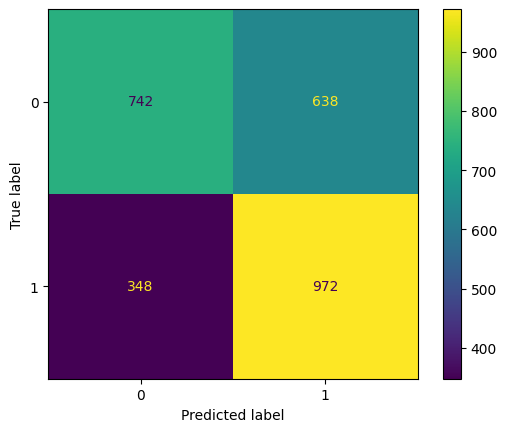

In [65]:
displayStats(cbm, "CATBOOST REV 2", X_test_Cr, y_test_Cr)

The frame by frame accuracy is worse, due to the less shuffled nature of the training dataset (we're shuffling in 60-frame chunks, instead of single frame shuffling)

Let's attempt to use this classifier to vote on clips, but if this does not work well, we may need to explore alternative strategies.

5) Classify 60 frames at a time (one clip) and take a majority consensus to classify a clip.

In [66]:
preds = []
softpreds = []
for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
    clip = np.reshape(clip,(1,-1))
    numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
    numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
    clip = np.reshape(clip,(numrows, numcols))
    
    #classify each row in clip
    clipPreds = cbm.predict(clip)
    clipSoftPreds = cbm.predict_proba(clip)[:,1]
    #softprediction = np.mean(clipSoftPreds)
    softprediction = np.median(clipSoftPreds)
    
    # prediction = np.sum(clipPreds)
    # if(prediction < (clipPreds.shape[0]/2)):
    #     prediction = 0
    # else:
    #     prediction = 1
    if(softprediction>=0.5):
        prediction = 1
    else:
        prediction = 0

    preds.append(prediction)
    softpreds.append(softprediction)
preds = np.asarray(preds)
softpreds = np.asarray(softpreds)

ACCURACY: 0.6666666666666666
ROC AUC: 0.7292490118577075


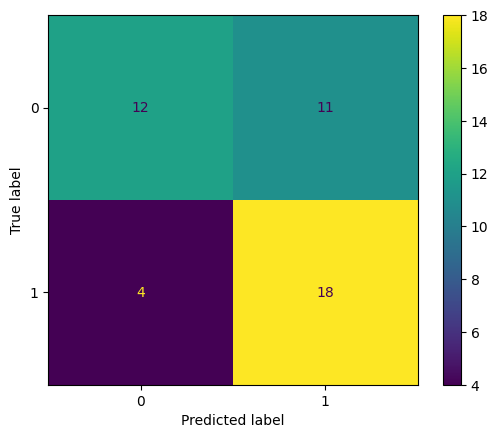

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

preds = np.reshape(preds,(-1,1))
print("ACCURACY: "+str(accuracy_score(y_test_C,preds)))
print("ROC AUC: "+str(roc_auc_score(y_test_C,softpreds)))

cmat = confusion_matrix(y_test_C,preds)
disp = ConfusionMatrixDisplay(cmat)
disp.plot()
plt.show()

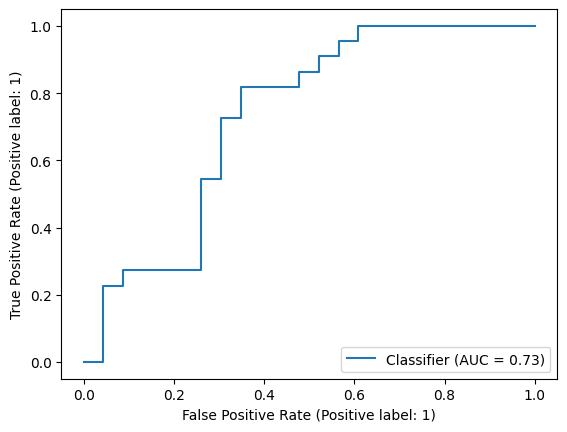

In [68]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test_C,softpreds)

The accuracy and roc-auc are decent. One possible hyperparameter that we can tune to improve it is the bias when computing the voted score. Currently, bad frames and good frames contribute equally to the clip's prediction. However, we can adjust this to bias more towards good frames, or more towards bad frames, and see if we can boost the accuracy. 

First however, we need to generate a histogram to look at accuracy and roc-auc across multiple runs.

## Sanity Check
Generating histogram for clip classifier

---

In [70]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot

accuracies = []
roc_aucs = []

for i in range(100):
    #get the data
    data_C = pd.read_csv("data_concat.csv",header=None)
    data_C = data_C.sample(frac=1)
    data_C = data_C.reset_index(drop=True)
    labels_C = data_C[0]
    data_C = data_C.drop(0,axis='columns')
    X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
    X_train_C = X_train_C.to_numpy()
    X_test_C = X_test_C.to_numpy()
    y_train_C = np.asarray(y_train_C.values.tolist())
    y_train_C = y_train_C.reshape(-1,1)
    y_test_C = np.asarray(y_test_C.values.tolist())
    y_test_C = y_test_C.reshape(-1,1)

    #transform
    newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
    X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

    newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
    X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

    y_train_Cr = np.copy(y_train_C)
    y_test_Cr = np.copy(y_test_C)

    y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
    y_train_Cr = np.reshape(y_train_Cr,(-1,1))
    y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
    y_test_Cr = np.reshape(y_test_Cr,(-1,1))

    # fit classifier
    _cbm = CatBoostClassifier(silent=True)
    _cbm.fit(X_train_Cr,y_train_Cr)
    preds = []
    softpreds = []
    for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
        clip = np.reshape(clip,(1,-1))
        numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
        numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
        clip = np.reshape(clip,(numrows, numcols))
        
        #classify each row in clip
        clipPreds = _cbm.predict(clip)
        clipSoftPreds = _cbm.predict_proba(clip)[:,1]
        #softprediction = np.mean(clipSoftPreds)
        softprediction = np.median(clipSoftPreds)
        if(softprediction>=0.5):
            prediction = 1
        else:
            prediction = 0

        # prediction = np.sum(clipPreds)
        # if(prediction < (clipPreds.shape[0]/2)):
        #     prediction = 0
        # else:
        #     prediction = 1
        
        preds.append(prediction)
        softpreds.append(softprediction)
    preds = np.asarray(preds)
    softpreds = np.asarray(softpreds)
    preds = np.reshape(preds,(-1,1))
    
    accuracies.append(accuracy_score(y_test_C,preds))
    roc_aucs.append(roc_auc_score(y_test_C,softpreds))

<Figure size 640x480 with 0 Axes>

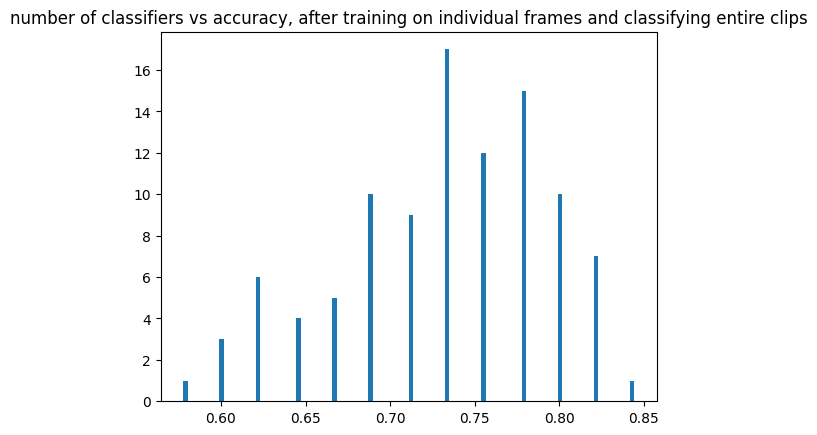

<Figure size 640x480 with 0 Axes>

In [71]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

<Figure size 640x480 with 0 Axes>

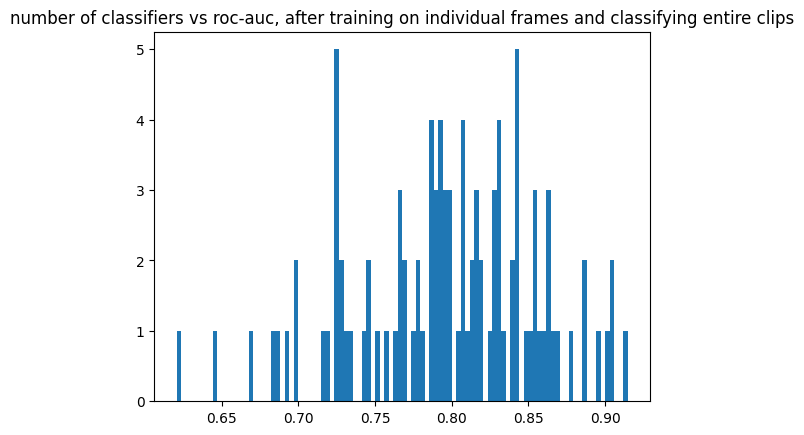

<Figure size 640x480 with 0 Axes>

In [72]:
plt.hist(roc_aucs,bins=100)
plt.title("number of classifiers vs roc-auc, after training on individual frames and classifying entire clips")
plt.figure()

In [73]:
accuracies = np.asarray(accuracies)
print("STD Deviation of accuracy: "+str(np.std(accuracies)))
print("mean of accuracy: "+str(np.mean(accuracies)))
print("median accuracy: "+str(np.median(accuracies)))

STD Deviation of accuracy: 0.061383232519702825
mean of accuracy: 0.7311111111111112
median accuracy: 0.7333333333333333


In [74]:
roc_aucs = np.asarray(roc_aucs)
print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs)))
print("mean of ROC-AUC: "+str(np.mean(roc_aucs)))
print("median ROC-AUC: "+str(np.median(roc_aucs)))

STD Deviation of ROC-AUC: 0.059554060323922436
mean of ROC-AUC: 0.796858880610878
median ROC-AUC: 0.797989898989899


## Bias parameter tuning

Tuning the proportion of good/bad frames to classify a clip

---

Mean accuracy: 0.6875555555555555
Mean ROC-AUC: 0.7825831804647554
STD Deviation of accuracy: 0.07123738788093487
STD Deviation of ROC-AUC: 0.056971151764860166

Mean accuracy: 0.7333333333333333
Mean ROC-AUC: 0.7976602062714981
STD Deviation of accuracy: 0.05443310539518174
STD Deviation of ROC-AUC: 0.0530224957381347

Mean accuracy: 0.6626666666666666
Mean ROC-AUC: 0.798414087944776
STD Deviation of accuracy: 0.07783363073937945
STD Deviation of ROC-AUC: 0.05886749175852957



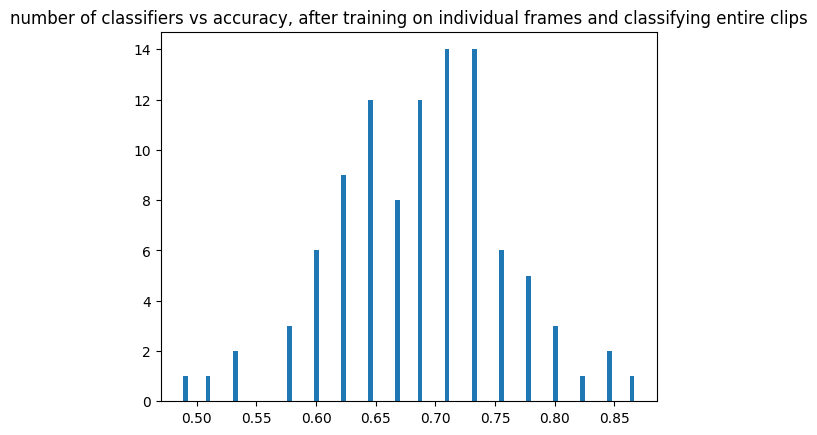

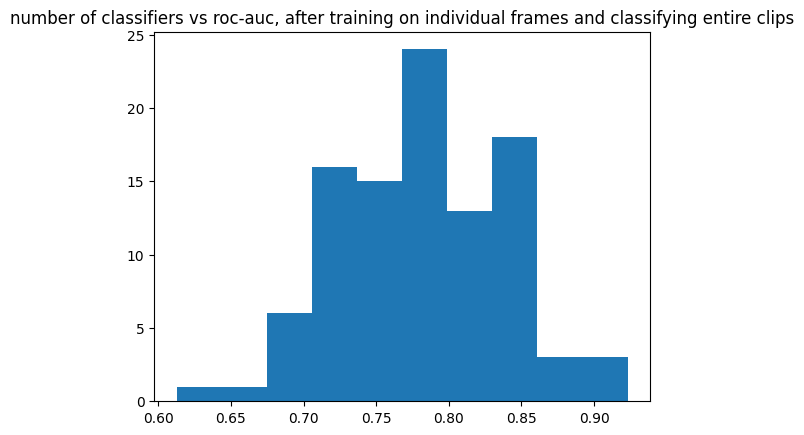

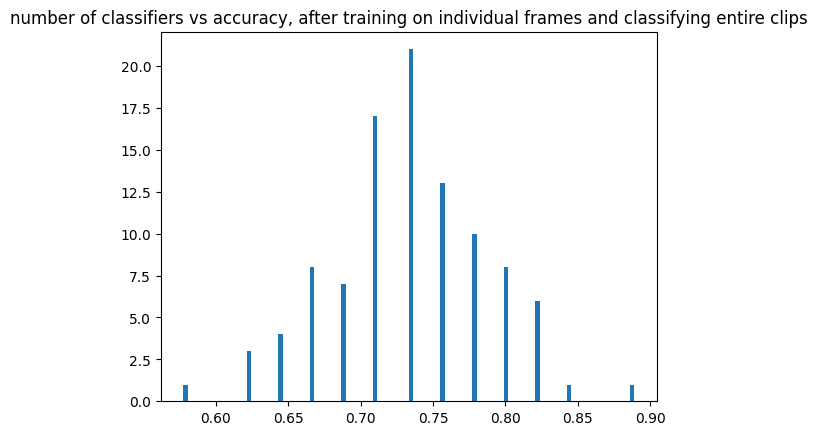

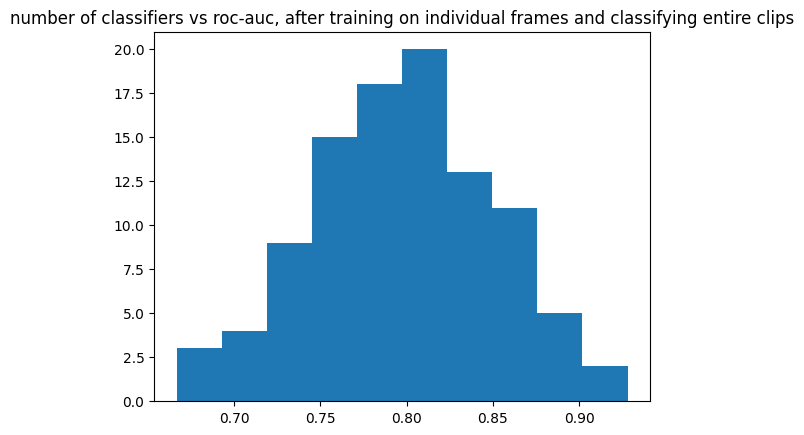

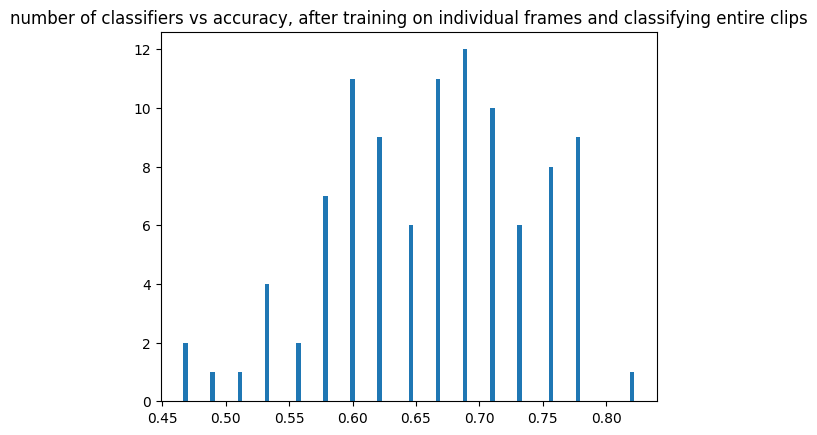

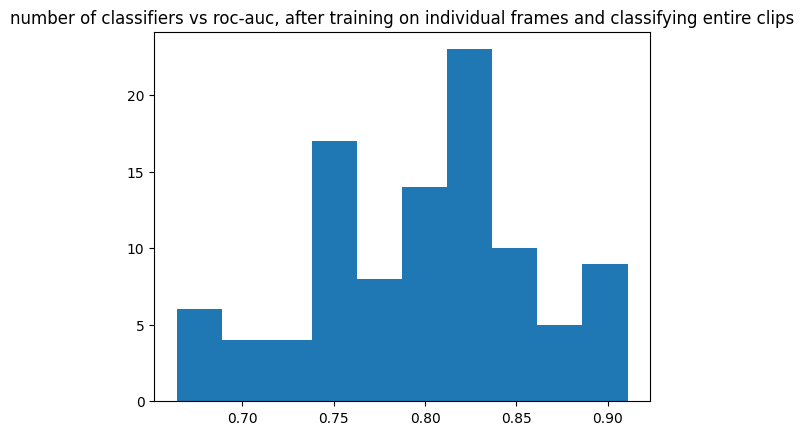

<Figure size 640x480 with 0 Axes>

In [76]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot


for bias in [1/4,1/2,3/4]:
    accuracies = []
    roc_aucs = []
    for i in range(100):
        #get the data
        data_C = pd.read_csv("data_concat.csv",header=None)
        data_C = data_C.sample(frac=1)
        data_C = data_C.reset_index(drop=True)
        labels_C = data_C[0]
        data_C = data_C.drop(0,axis='columns')
        X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
        X_train_C = X_train_C.to_numpy()
        X_test_C = X_test_C.to_numpy()
        y_train_C = np.asarray(y_train_C.values.tolist())
        y_train_C = y_train_C.reshape(-1,1)
        y_test_C = np.asarray(y_test_C.values.tolist())
        y_test_C = y_test_C.reshape(-1,1)

        #transform
        newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
        X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

        newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
        X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

        y_train_Cr = np.copy(y_train_C)
        y_test_Cr = np.copy(y_test_C)

        y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
        y_train_Cr = np.reshape(y_train_Cr,(-1,1))
        y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
        y_test_Cr = np.reshape(y_test_Cr,(-1,1))

        # fit classifier
        _cbm = CatBoostClassifier(silent=True)
        _cbm.fit(X_train_Cr,y_train_Cr)
        preds = []
        softpreds = []
        for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
            clip = np.reshape(clip,(1,-1))
            numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
            numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
            clip = np.reshape(clip,(numrows, numcols))
            
            #classify each row in clip
            clipPreds = _cbm.predict(clip)
            clipSoftPreds = _cbm.predict_proba(clip)[:,1]
            # softprediction = np.average(clipSoftPreds)
            
            # prediction = np.sum(clipPreds)
            # if(prediction < int(clipPreds.shape[0]*bias)): 
            #     prediction = 0
            # else:
            #     prediction = 1
            softprediction = np.median(clipSoftPreds)

            #added biasing
            softprediction = softprediction * ((0.5)/bias)
            if(softprediction<0):
                softprediction = 0
            elif(softprediction>1):
                softprediction = 1
            
            if(softprediction>=0.5):
                prediction = 1
            else:
                prediction = 0
            
            preds.append(prediction)
            softpreds.append(softprediction)
        preds = np.asarray(preds)
        softpreds = np.asarray(softpreds)
        preds = np.reshape(preds,(-1,1))
        
        accuracies.append(accuracy_score(y_test_C,preds))
        roc_aucs.append(roc_auc_score(y_test_C,softpreds))
    
    plt.hist(accuracies,bins=100)
    plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
    plt.figure()
    plt.hist(roc_aucs,bins=10)
    plt.title("number of classifiers vs roc-auc, after training on individual frames and classifying entire clips")
    plt.figure()
    accuracies = np.asarray(accuracies)
    roc_aucs = np.asarray(roc_aucs)
    print("Mean accuracy: "+str(np.mean(accuracies)))
    print("Mean ROC-AUC: "+str(np.mean(roc_aucs)))
    print("STD Deviation of accuracy: "+str(np.std(accuracies)))
    print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs))+"\n")


The bias parameter that has the best accuracy also does not differ greatly from the others in ROC-AUC. As such, I believe that having 1/2 as the bias parameter (good and bad frames equally weighted) is the best, so that we get a good result on both metrics. If ROC-AUC is the only metric that we want to consider, then a bias of 3/4ths performs better.

### Conclusion of Clip Classifier using frame classification

---

We can see that the accuracy has improved over the raw clip classification, and that the standard deviation of that accuracy itself has gone down. This makes sense, as the classifier has much more data to train on, and can better. By classifying the frames of each clip and taking a majority vote of good frames vs bad frames, it also softens the impact of minor deviations, whereas if classifying the entire clip all at once, it is possible that a deviation at a certain point in the shot affects the classification very strongly. This approach classes deviations equally, and doesn't let one bad frame outweigh multiple good frames.

The downside of this approach is that it completely disregards the temporal relationship between the frames themselves. If there is a good shot, and it's frames were scrambled, it would not actually be visually representative of a good basketball free throw. However, this classifier will still likely identify it as a good shot. 

Our other attempts of using different types of classifiers all performed worse than this one. We also tried to design a model where we had independent classifiers for each quarter of a clip, with a similar voting scheme to the model above, but this one did not perform much better, and was not worth the added complexity.

In [ ]:
import pickle
with open('r2cboost.pk1','wb') as file:
    pickle.dump(cbm,file)